In [1]:
import scipy.stats as sps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare

In [2]:
df=pd.read_csv('Data.csv')



In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%Y-%m-%d')

In [4]:
df['InvoiceDate'] = df['InvoiceDate'].dt.strftime('%Y-%m-%d')

In [5]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
944463,575312,22083,PAPER CHAIN KIT RETROSPOT,6,2011-11-09,2.95,13588.0,United Kingdom
944464,575312,23355,HOT WATER BOTTLE KEEP CALM,4,2011-11-09,4.95,13588.0,United Kingdom
944465,575312,22110,BIRD HOUSE HOT WATER BOTTLE,6,2011-11-09,2.55,13588.0,United Kingdom
944466,575312,22037,ROBOT BIRTHDAY CARD,12,2011-11-09,0.42,13588.0,United Kingdom


In [6]:
df[df['Quantity']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
944223,C575224,21928,JUMBO BAG SCANDINAVIAN BLUE PAISLEY,-100,2011-11-09,1.79,17511.0,United Kingdom
944237,C575257,M,Manual,-4,2011-11-09,10.95,13623.0,United Kingdom
944238,C575257,37449,CERAMIC CAKE STAND + HANGING CAKES,-1,2011-11-09,9.95,13623.0,United Kingdom
944239,C575257,11001,ASSTD DESIGN RACING CAR PEN,-1,2011-11-09,1.69,13623.0,United Kingdom


In [7]:
df['Quantity']=abs(df['Quantity'])
df['Price']=abs(df['Price'])

In [8]:
df['Total']=df['Quantity']*df['Price']
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
944463,575312,22083,PAPER CHAIN KIT RETROSPOT,6,2011-11-09,2.95,13588.0,United Kingdom,17.70
944464,575312,23355,HOT WATER BOTTLE KEEP CALM,4,2011-11-09,4.95,13588.0,United Kingdom,19.80
944465,575312,22110,BIRD HOUSE HOT WATER BOTTLE,6,2011-11-09,2.55,13588.0,United Kingdom,15.30
944466,575312,22037,ROBOT BIRTHDAY CARD,12,2011-11-09,0.42,13588.0,United Kingdom,5.04


In [9]:
df_group=df.groupby(['InvoiceDate', 'Customer ID']).agg({'Total': ['sum']}). reset_index()

In [10]:
df_group.columns = df_group.columns.droplevel(1)

In [11]:
df_group['Customer ID'] = df_group['Customer ID'].astype(str)

In [12]:
df_group['id'] = df_group['InvoiceDate'] +' '+df_group['Customer ID']

In [13]:
df_res=df_group[['id', 'Total']]
df_res

,id,Total
0,2009-12-01 12362.0,130.00
1,2009-12-01 12490.0,603.94
2,2009-12-01 12533.0,929.92
3,2009-12-01 12615.0,5.95
4,2009-12-01 12636.0,141.00
...,...,...
35750,2011-11-09 17841.0,446.98
35751,2011-11-09 17865.0,1130.74
35752,2011-11-09 18109.0,261.20
35753,2011-11-09 18144.0,315.00


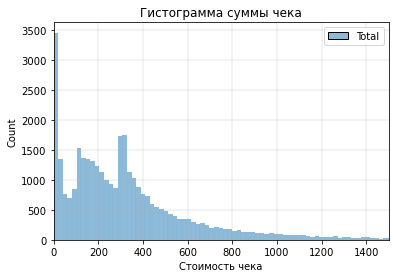

In [14]:
sns.histplot(df_res)
plt.title("Гистограмма суммы чека")
plt.xlabel("Стоимость чека")
plt.grid(linewidth=0.3) 
plt.xlim(0, 1500)
plt.show()

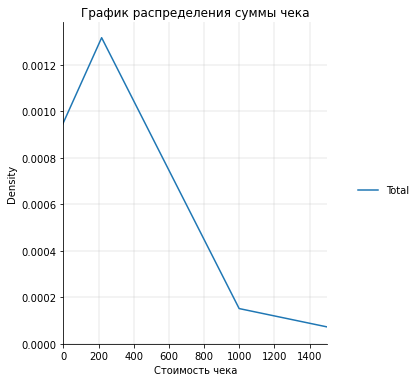

In [15]:
sns.displot(df_res, kind='kde')
plt.title("График распределения суммы чека")
plt.xlabel("Стоимость чека")
plt.grid(linewidth=0.3) 
plt.xlim(0, 1500)
plt.show()

In [16]:
x = np.linspace (df_res['Total'].min(), df_res['Total'].max(), df_res['Total'].shape[0])


In [17]:
y1 = sps.gamma.pdf (x, a=3 , scale=150)

(0.0, 300.0)

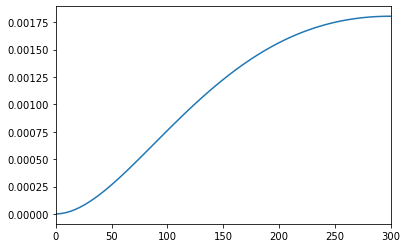

In [18]:
plt.plot (x, y1)
plt.xlim(0,300)

In [88]:
y2 = sps.chi2.pdf (x,6 ,loc=-150, scale=100)

(0.0, 300.0)

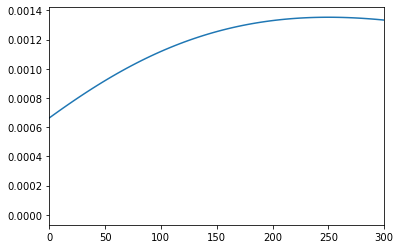

In [89]:
plt.plot (x, y2)
plt.xlim(0,300)

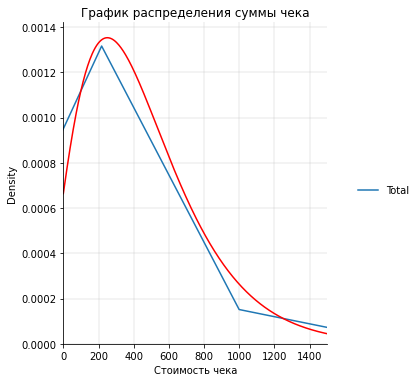

In [90]:
sns.displot(df_res, kind='kde')
plt.plot (x, y2, color='red')
plt.xlim(0,300)
plt.title("График распределения суммы чека")
plt.xlabel("Стоимость чека")
plt.grid(linewidth=0.3) 
plt.xlim(0, 1500)
plt.show()

In [21]:
a=np.array(df_res['Total'])
a

array([130.  , 603.94, 929.92, ..., 261.2 , 315.  , 355.32])

In [22]:
def pdf(k: int, rnd_list: list):
    """
    Получает кривую плотности распределения вероятности
    :param k: количечиво интервалов разбиения гистограммы
    :param rnd_list: случайный процесс
    :return: pandas.DataFrame
    """
    pdf_x = []  # Координаты по оси абсцисс
    pdf_y = []  # Координаты по оси ординат
    n = len(rnd_list)  # количество элементов в рассматриваемой выборке
    h = (max(rnd_list) - min(rnd_list)) / k  # ширина одного интервала
    a = min(rnd_list)  # минимальное значение в рассматриваемой выборке
    for i in range(0, k):  # проход по интервалам
        count = 0
        for j in rnd_list:  # подсчет количества вхождений значений из выборки в данный интервал
            if (a + i * h) < j < (a + (i * h) + h):
                count = count + 1
        pdf_x.append(a + i * h + h / 2)  # координата по оси абсцисс полученной кривой плотности распределения
        # вероятности
        pdf_y.append(count / (n * h))  # координата по оси ординат полученной кривой плотности распределения
        # вероятности
    d = {'x': pdf_x, 'y': pdf_y}
    return pd.DataFrame(d)

In [23]:
r_pdf = pdf(df_res['Total'].shape[0], df_res['Total'])
r_pdf['y']

0        0.004450
1        0.005409
2        0.005098
3        0.004567
4        0.003246
           ...   
35750    0.000000
35751    0.000000
35752    0.000000
35753    0.000000
35754    0.000000
Name: y, Length: 35755, dtype: float64

In [24]:
a=np.array(r_pdf['y'])
a

array([0.00445043, 0.00540918, 0.00509823, ..., 0.        , 0.        ,
       0.        ])

In [25]:
b=np.array(y1)
b

array([0.00000000e+00, 2.68322210e-06, 1.04283651e-05, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [26]:
sum(a)

0.2315971268507845

In [27]:
sum(b)

0.23161656036875117

In [28]:
a=a/sum(a)*sum(b)

In [29]:
with np.errstate(divide='ignore', invalid='ignore'):
    k=chisquare(f_obs=a, f_exp=b,ddof=0)
    print(k)

Power_divergenceResult(statistic=nan, pvalue=nan)


In [ ]:
sco_d = np.sqrt(2/(n-1)) * d
sco_d

In [91]:
sco_d = np.sqrt(2/(5-1)) * 2


In [92]:
sco_d

1.4142135623730951

In [93]:
a=2/(5-1)

In [94]:
a

0.5

In [95]:
np.sqrt(a) * 2

1.4142135623730951